In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
order_reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
geolocation = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
product_category_name_translation = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


**Some basic data cleaning here, 1) the datasets are merged together 2) duplicates are removed 3) the missing rows are explored**

**The major data is well-organised, with a few missing data. 1) order_delivered_carrier_date:1155  2) Missing rows in order_delivered_customer_date:2386**

In [2]:
print('Total number of duplicated order_id : {}'.format(orders.shape[0] - len(orders['order_id'].unique())))
print('Total number of duplicated customer_id : {}'.format(customers.shape[0] - len(customers['customer_id'].unique())))
orders = orders.drop_duplicates()
data_order_customer = pd.merge(orders, customers, on = 'customer_id', how = 'inner')

order_items.drop_duplicates()
print('Total number of duplicated seller_id : {}'.format(sellers.shape[0] - len(sellers['seller_id'].unique())))
print('Number of sellers : {}, Number of orders_item:{}'.format(sellers.shape[0],order_items.shape[0]))
data_order__item_seller = pd.merge(order_items, sellers, on = 'seller_id', how = 'inner')

data = pd.merge(data_order_customer, data_order__item_seller, on = 'order_id', how = 'inner')
data.dropna()
data = pd.merge(products, data, on = 'product_id', how = 'inner')
data = pd.merge(product_category_name_translation, data, on = 'product_category_name', how = 'inner')
missing_data = data.isnull().sum()
for i in range(len(missing_data)):
    print('Missing rows in {}:{}'.format(missing_data.index[i], missing_data.values[i]))

Total number of duplicated order_id : 0
Total number of duplicated customer_id : 0
Total number of duplicated seller_id : 0
Number of sellers : 3095, Number of orders_item:112650
Missing rows in product_category_name:0
Missing rows in product_category_name_english:0
Missing rows in product_id:0
Missing rows in product_name_lenght:0
Missing rows in product_description_lenght:0
Missing rows in product_photos_qty:0
Missing rows in product_weight_g:1
Missing rows in product_length_cm:1
Missing rows in product_height_cm:1
Missing rows in product_width_cm:1
Missing rows in order_id:0
Missing rows in customer_id:0
Missing rows in order_status:0
Missing rows in order_purchase_timestamp:0
Missing rows in order_approved_at:14
Missing rows in order_delivered_carrier_date:1155
Missing rows in order_delivered_customer_date:2386
Missing rows in order_estimated_delivery_date:0
Missing rows in customer_unique_id:0
Missing rows in customer_zip_code_prefix:0
Missing rows in customer_city:0
Missing rows 

**From the geopraph drawn using zip-code, it came out with some outliers which lies out of Brazil territory.
So, the maximum and minimum of latitude and longtitude are utilized to remove the outliers.**

In [3]:

# print('Total number of duplicated zip_code_prefix : {}'.format(geolocation.shape[0] - len(geolocation['geolocation_zip_code_prefix'].unique())))
# print(geolocation['geolocation_zip_code_prefix'].value_counts())

tmp = geolocation[['geolocation_zip_code_prefix']].apply(pd.value_counts).sum(1)
geolocation = geolocation.assign(zip_code_count = geolocation['geolocation_zip_code_prefix'].map(tmp))
geolocation = geolocation.drop_duplicates(['geolocation_zip_code_prefix'])
geolocation.sort_values(by = 'zip_code_count', ascending = False,inplace = True)

geolocation['geolocation_lat'] = geolocation['geolocation_lat'].astype(float)
geolocation['geolocation_lng'] = geolocation['geolocation_lng'].astype(float)

# geomap = gpd.GeoDataFrame(geolocation, geometry = gpd.points_from_xy(geolocation['geolocation_lng'],geolocation['geolocation_lat']))
# geomap.plot(k = 6, figsize = (9,9),color = '#2BB7B3')
# plt.show()

geolocation = geolocation[(geolocation.geolocation_lat <= (float)(5.27438888))]
geolocation = geolocation[((float)(-33.75116944) <= geolocation.geolocation_lat)]
geolocation = geolocation[((float)(-73.98283055) <= geolocation.geolocation_lng)]
geolocation = geolocation[(geolocation.geolocation_lng <= (float)(-34.79314722))]


import unicodedata

def trans(mystr):
    k = unicodedata.normalize('NFKD',mystr).encode('ascii','ignore')
    if(mystr != k.decode('ascii')):
        print(mystr,'  ',k.decode('ascii'))
        
    return k.decode('ascii')

geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(trans)


niterói    niteroi
vitória    vitoria
são josé do rio pardo    sao jose do rio pardo
florianópolis    florianopolis
niterói    niteroi
são lourenço    sao lourenco
guaxupé    guaxupe
são paulo    sao paulo
uberlândia    uberlandia
niterói    niteroi
jundiaí    jundiai
bagé    bage
teófilo otoni    teofilo otoni
guarujá    guaruja
niterói    niteroi
são paulo    sao paulo
hortolândia    hortolandia
barra do garças    barra do garcas
itajubá    itajuba
simões filho    simoes filho
mauá    maua
são bernardo do campo    sao bernardo do campo
são paulo    sao paulo
santo andré    santo andre
são josé dos campos    sao jose dos campos
muriaé    muriae
santo andré    santo andre
goiânia    goiania
itajaí    itajai
são paulo    sao paulo
são bernardo do campo    sao bernardo do campo
pará de minas    para de minas
são paulo    sao paulo
são paulo    sao paulo
florianópolis    florianopolis
joão pessoa    joao pessoa
são bernardo do campo    sao bernardo do campo
paulínia    paulinia
são josé d

Two maps are build.

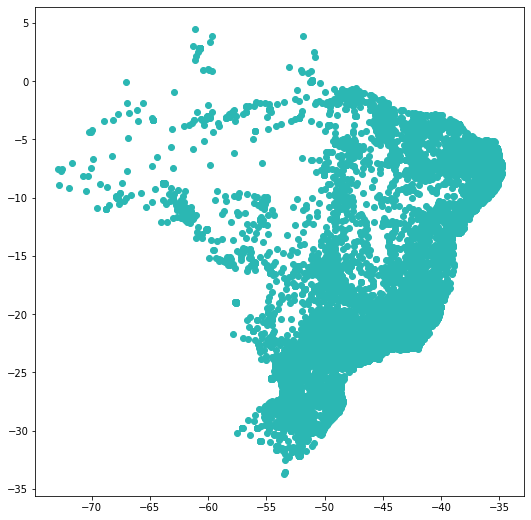

In [4]:
geomap = gpd.GeoDataFrame(geolocation, geometry = gpd.points_from_xy(geolocation['geolocation_lng'],geolocation['geolocation_lat']))
geomap.plot(k = 6, figsize = (9,9),color = '#2BB7B3')
plt.show()

**Here, a dataset containing geolocation of sellers and cutomers are made in order to explore the relation btween the number of orders and order distance.**

**In order to calulate the distance between two places using latitude and longtitude. However, this can be conducted by using some libraries.**

In [5]:
data_seller_customer = data[['seller_zip_code_prefix','customer_zip_code_prefix']]
print(data_seller_customer.shape, geolocation.shape)
geolocation.rename(columns = {'geolocation_zip_code_prefix':'seller_zip_code_prefix'},inplace = True)
data_seller_customer = pd.merge(data_seller_customer, geolocation, on = 'seller_zip_code_prefix', how = 'inner')
data_seller_customer.rename(columns={
    'geolocation_lat':'seller_lat',
    'geolocation_lng': 'seller_lng',
    'geolocation_city':'seller_city',
    'geolocation_state':'seller_state'
    },inplace=True)

geolocation.rename(columns = {'seller_zip_code_prefix':'customer_zip_code_prefix'},inplace = True)
print(data_seller_customer.shape)

data_seller_customer = pd.merge(data_seller_customer, geolocation, on = 'customer_zip_code_prefix', how = 'inner')
data_seller_customer.rename(columns={
    'geolocation_lat':'customer_lat',
    'geolocation_lng': 'customer_lng',
    'geolocation_city':'customer_city',
    'geolocation_state':'customer_state'
    },inplace=True)
print(data_seller_customer.shape)

geolocation.rename(columns = {'customer_zip_code_prefix':'geolocation_zip_code_prefix'},inplace = True)
data_seller_customer.head()

(111023, 2) (19005, 7)
(110767, 8)
(110455, 14)


,seller_zip_code_prefix,customer_zip_code_prefix,seller_lat,seller_lng,seller_city,seller_state,zip_code_count_x,geometry_x,customer_lat,customer_lng,customer_city,customer_state,zip_code_count_y,geometry_y
0,94451,8599,-30.159469,-50.832839,viamao,RS,21,POINT (-50.83284 -30.15947),-23.462597,-46.335317,itaquaquecetuba,SP,123,POINT (-46.33532 -23.46260)
1,9015,8599,-23.665703,-46.518082,santo andre,SP,160,POINT (-46.51808 -23.66570),-23.462597,-46.335317,itaquaquecetuba,SP,123,POINT (-46.33532 -23.46260)
2,4186,8599,-23.652816,-46.599410,sao paulo,SP,55,POINT (-46.59941 -23.65282),-23.462597,-46.335317,itaquaquecetuba,SP,123,POINT (-46.33532 -23.46260)
3,2066,8599,-23.508759,-46.602973,sao paulo,SP,74,POINT (-46.60297 -23.50876),-23.462597,-46.335317,itaquaquecetuba,SP,123,POINT (-46.33532 -23.46260)
4,5424,8599,-23.571258,-46.696331,sao paulo,SP,93,POINT (-46.69633 -23.57126),-23.462597,-46.335317,itaquaquecetuba,SP,123,POINT (-46.33532 -23.46260)


**Below is the map of relationships between number of orders and the distance between sellers and customers.**

In [6]:
from math import radians, cos, sin, asin, sqrt

def geodistance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance=2*asin(sqrt(a))*6371*1000 
    distance=round(distance/1000,3)
    return distance

# data_seller_customer['distance'] = data_seller_customer[['seller_lng','seller_lat','customer_lng','customer_lat']].apply(geodistance, axis = 1)
A = data_seller_customer['seller_lng'].tolist()
B = data_seller_customer['seller_lat'].tolist()
C = data_seller_customer['customer_lng'].tolist()
D = data_seller_customer['customer_lat'].tolist()
data_seller_customer['distance'] = data_seller_customer['seller_lat']
for i in range(len(A)):
    data_seller_customer.distance.loc[i] = geodistance(A[i],B[i],C[i],D[i])

# data_seller_customer['distance'] = geodistance(data_seller_customer['seller_lng'].tolist(),data_seller_customer['seller_lat'].tolist(), data_seller_customer['customer_lng'].tolist(),data_seller_customer['customer_lat'].tolist())

data_seller_customer.head()

data_seller_customer.shape[0]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


110455

**Further, to explore the top sellers and customers by number of products sold/bought, df1 and df2 are conducted.**

[0.00000000e+00 7.15618324e-01 1.43123665e+00 ... 3.57594476e+03
 3.57666038e+03 3.57737600e+03]


Text(0.5, 1.0, 'Relation of number of orders and distance between sellers and customers')

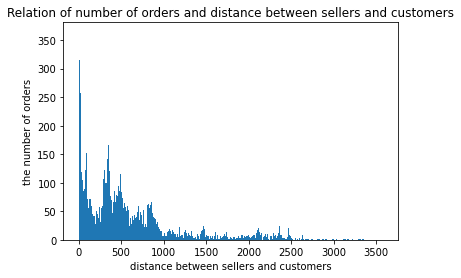

In [7]:
data_seller_customer = data_seller_customer.sort_values(by = ['distance'])
distance = data_seller_customer['distance'].tolist()
bins = np.linspace(min(distance), max(distance), 5000)
print(bins)
plt.hist(distance,bins)
plt.xlabel('distance between sellers and customers')
plt.ylabel('the number of orders')
plt.title('Relation of number of orders and distance between sellers and customers')


**A histogram is conducted to visualize it. From which, a city stands out - ibitinga sells so much (top 3), but only buys 24 products. So more exploration are conducted in that city.**

In [8]:
df1 = data_seller_customer[['seller_city','customer_city']]
df1['seller_customer_pair'] = df1.apply(lambda x: (x['seller_city'], x['customer_city']), axis = 1)

seller_single = df1[['seller_city']].apply(pd.value_counts).sum(1)
customer_single = df1[['customer_city']].apply(pd.value_counts).sum(1)
df1 = df1.assign(seller_count = df1['seller_city'].map(seller_single))
df1 = df1.assign(customer_count = df1['seller_city'].map(customer_single))
df1['single_count'] = df1['seller_count'] + df1['customer_count']

pair = df1[['seller_customer_pair']].apply(pd.value_counts).sum(1)
df1 = df1.assign(pair_count = df1['seller_customer_pair'].map(pair))
df1.drop_duplicates('seller_customer_pair', inplace = True)
df1 = df1.reset_index(drop = True)

counts = 0
for i in range(df1.shape[0]):
    counts = counts + df1.loc[i,'pair_count']

df2 = df1.drop_duplicates('seller_city', inplace = False)
df2.sort_values(by = 'single_count', ascending= False, inplace = True)
df2 = df2.reset_index(drop = True)

print('the total number of orders ', counts)
print('the total number of distinct seller & customer_cities ', df2.shape[0])

x_axis = df2.loc[:9,'seller_city'].to_numpy()
y_axis = x_axis

xy = [[0 for i in range(len(x_axis))] for i in range(len(x_axis))]
              
for i in range(df1.shape[0]):
    for ix in range(len(x_axis)):
        if(x_axis[ix] == df1.loc[i,'seller_city']):
            for iy in range(len(y_axis)):
                if(y_axis[iy] == df1.loc[i,'customer_city']):
                    xy[ix][iy] = df1.loc[i,'pair_count']

print(xy)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


the total number of orders  110455
the total number of distinct seller & customer_cities  550
[[4771, 1647, 4, 683, 414, 232, 363, 94, 415, 130], [313, 324, 0, 73, 44, 19, 19, 7, 16, 7], [1336, 602, 1, 224, 69, 64, 81, 31, 132, 51], [288, 174, 0, 152, 40, 24, 26, 4, 27, 10], [409, 209, 0, 101, 128, 17, 25, 13, 41, 16], [497, 181, 1, 56, 30, 23, 38, 11, 41, 12], [338, 104, 0, 40, 30, 25, 29, 9, 46, 12], [327, 223, 1, 87, 36, 15, 23, 19, 48, 15], [228, 98, 1, 29, 18, 15, 18, 3, 37, 7], [383, 181, 0, 72, 42, 16, 27, 9, 28, 21]]


[Text(0, 0.5, 'sao paulo'),
 Text(0, 1.5, 'rio de janeiro'),
 Text(0, 2.5, 'ibitinga'),
 Text(0, 3.5, 'belo horizonte'),
 Text(0, 4.5, 'curitiba'),
 Text(0, 5.5, 'santo andre'),
 Text(0, 6.5, 'guarulhos'),
 Text(0, 7.5, 'sao jose do rio preto'),
 Text(0, 8.5, 'campinas'),
 Text(0, 9.5, 'ribeirao preto')]

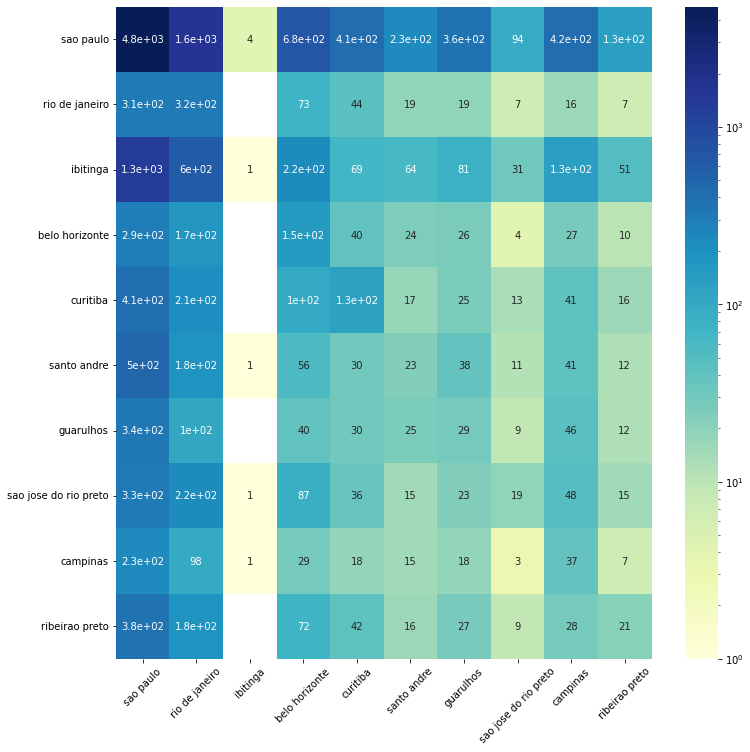

In [9]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (12,12))
ax = sns.heatmap(xy, cmap = 'YlGnBu', annot = True, norm = LogNorm())
ax.set_xticklabels(x_axis, rotation = '45')
ax.set_yticklabels(y_axis, rotation = 'horizontal')

# df2['seller_city_name'] = df2['seller_city'].apply(trans)
# df2['customer_city_name'] = df2['customer_city'].apply(trans)


**A wordmap is formed, with category English names on it.**

In [10]:
data
data_product_geolocation = data[['seller_city','customer_city','product_category_name','product_category_name_english']]
data_product_geolocation_ibitinga = data_product_geolocation[data_product_geolocation['seller_city'] == 'ibitinga']
# data_product_geolocation_ibitinga = data_product_geolocation_ibitinga[data_product_geolocation_ibitinga['customer_city'] == 'sao paulo']

data_product_geolocation_ibitinga

,seller_city,customer_city,product_category_name,product_category_name_english
18415,ibitinga,embu-guacu,automotivo,auto
18416,ibitinga,barao de cocais,automotivo,auto
18417,ibitinga,rio de janeiro,automotivo,auto
18418,ibitinga,maracanau,automotivo,auto
18717,ibitinga,ribeirao pires,automotivo,auto
...,...,...,...,...
110757,ibitinga,rio novo do sul,casa_conforto_2,home_comfort_2
110758,ibitinga,aparecida,casa_conforto_2,home_comfort_2
110759,ibitinga,santos,casa_conforto_2,home_comfort_2
110760,ibitinga,santos,casa_conforto_2,home_comfort_2


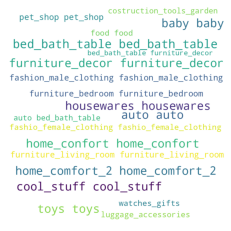

In [11]:
import wordcloud as wc

words = ' '.join(data_product_geolocation_ibitinga.product_category_name_english)

w = wc.WordCloud(width = 1000, height = 1000, min_font_size = 30, max_words = 300, relative_scaling = 0, background_color='white')
w.generate(words)
w.to_file('wordcloud.png')
plt.axis("off")
plt.imshow(w)

In [12]:
geoproduct = data[['price','seller_city','customer_city']]
city_sales = pd.DataFrame()
city_sales = geoproduct.groupby(by = 'seller_city',as_index = False).agg({'price':sum})
city_sales.sort_values(by = 'price',ascending= False,inplace = True)

city_sales


,seller_city,price
511,sao paulo,2673549.42
225,ibitinga,622324.13
158,curitiba,460364.27
444,rio de janeiro,345923.02
219,guarulhos,279139.81
...,...,...
433,resende,19.99
186,floranopolis,19.98
277,jarinu,14.63
308,macatuba,13.00


[Text(0, 0, 'sao paulo'),
 Text(1, 0, 'ibitinga'),
 Text(2, 0, 'curitiba'),
 Text(3, 0, 'rio de janeiro'),
 Text(4, 0, 'guarulhos'),
 Text(5, 0, 'ribeirao preto'),
 Text(6, 0, 'itaquaquecetuba'),
 Text(7, 0, 'guariba'),
 Text(8, 0, 'santo andre'),
 Text(9, 0, 'lauro de freitas')]

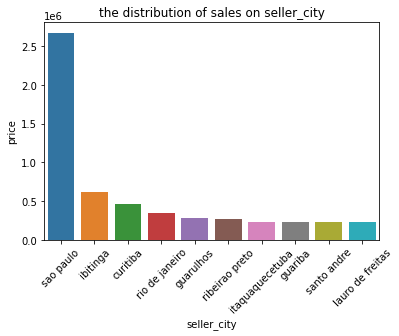

In [13]:
city_sales = city_sales.reset_index(drop = True)
city_sales
tmp = city_sales.loc[:9]
# tmp['price'] = tmp['price'].apply(np.log10)
ax = sns.barplot(x = 'seller_city', y = 'price',data = tmp)
ax.set(title = 'the distribution of sales on seller_city')
ax.set_xticklabels(labels = tmp['seller_city'],rotation = 45)


In [14]:
geoproduct = data[['price','seller_city','customer_city']]

city_sales = geoproduct.groupby(by = 'customer_city',as_index = False).agg({'price':sum})
city_sales.sort_values(by = 'price',ascending= False,inplace = True)

city_sales

,customer_city,price
3576,sao paulo,1886128.28
3136,rio de janeiro,980899.05
451,belo horizonte,350175.53
556,brasilia,299235.34
1139,curitiba,209901.64
...,...,...
1948,jenipapo de minas,7.48
3384,santo antonio do rio abaixo,6.00
3654,senador jose porfirio,6.00
3202,sabaudia,5.90


[Text(0, 0, 'sao paulo'),
 Text(1, 0, 'rio de janeiro'),
 Text(2, 0, 'belo horizonte'),
 Text(3, 0, 'brasilia'),
 Text(4, 0, 'curitiba'),
 Text(5, 0, 'porto alegre'),
 Text(6, 0, 'campinas'),
 Text(7, 0, 'salvador'),
 Text(8, 0, 'guarulhos'),
 Text(9, 0, 'niteroi')]

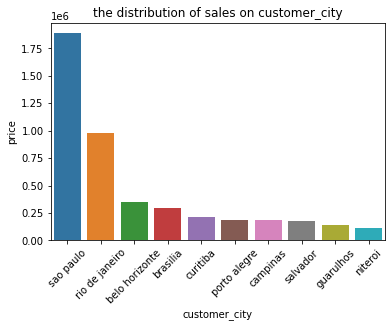

In [15]:
city_sales = city_sales.reset_index(drop = True)
city_sales
tmp = city_sales.loc[:9]
# tmp['price'] = tmp['price'].apply(np.log10)
ax = sns.barplot(x = 'customer_city', y = 'price',data = tmp)
ax.set(title = 'the distribution of sales on customer_city')
ax.set_xticklabels(labels = tmp['customer_city'],rotation = 45)


In [16]:
city_seller_sales = geoproduct.copy()
city_seller_sales = city_seller_sales.groupby(by = ['seller_city']).sum()
city_seller_sales = city_seller_sales.sort_values(by = 'price',ascending = False)
city_seller_sales = city_seller_sales.reset_index(drop = False)
dft1 = city_seller_sales
city_seller_sales = city_seller_sales.loc[:19,]
city_seller_sales

,seller_city,price
0,sao paulo,2673549.42
1,ibitinga,622324.13
2,curitiba,460364.27
3,rio de janeiro,345923.02
4,guarulhos,279139.81
5,ribeirao preto,273828.06
6,itaquaquecetuba,230568.12
7,guariba,229472.63
8,santo andre,228441.90
9,lauro de freitas,225525.05


In [17]:
# city_sales = city_sales.reset_index(drop = True)
# city_sales
# tmp = city_sales.loc[:9]
# # tmp['price'] = tmp['price'].apply(np.log10)
# ax = sns.barplot(x = 'seller_city', y = 'price',data = tmp)
# ax.set(title = 'the distribution of sales on seller_city')
# ax.set_xticklabels(labels = tmp['seller_city'],rotation = 45)


In [18]:
geoproduct = data[['price','seller_city','customer_city']]

city_sales = geoproduct.groupby(by = 'customer_city',as_index = False).agg({'price':sum})
city_sales.sort_values(by = 'price',ascending= False,inplace = True)

city_sales

,customer_city,price
3576,sao paulo,1886128.28
3136,rio de janeiro,980899.05
451,belo horizonte,350175.53
556,brasilia,299235.34
1139,curitiba,209901.64
...,...,...
1948,jenipapo de minas,7.48
3384,santo antonio do rio abaixo,6.00
3654,senador jose porfirio,6.00
3202,sabaudia,5.90


In [19]:
df = geoproduct.copy()
df1 = df.groupby(by = ['seller_city']).sum()
df = df1.sort_values(by = 'price', ascending = False)
df = df.reset_index(drop = False)
x_axis = df.loc[:9,'seller_city'].to_numpy()
print(x_axis)
print(geoproduct)

df = geoproduct.copy()
df2 = df.groupby(by = ['customer_city']).sum()
df = df2.sort_values(by = 'price', ascending = False)
df = df.reset_index(drop = False)
y_axis = df.loc[:9,'customer_city'].to_numpy()
print(y_axis)


['sao paulo' 'ibitinga' 'curitiba' 'rio de janeiro' 'guarulhos'
 'ribeirao preto' 'itaquaquecetuba' 'guariba' 'santo andre'
 'lauro de freitas']
         price       seller_city    customer_city
0        29.90            viamao  itaquaquecetuba
1        89.90            cuiaba    montes claros
2        95.90            cuiaba   rio de janeiro
3        29.90  lencois paulista       santa rosa
4        64.90          londrina          armazem
...        ...               ...              ...
111018   39.99      porto alegre         blumenau
111019   39.99      porto alegre        sao paulo
111020   39.99      porto alegre        sao paulo
111021  100.00           jacarei         brasilia
111022  183.29        piracicaba   rolim de moura

[111023 rows x 3 columns]
['sao paulo' 'rio de janeiro' 'belo horizonte' 'brasilia' 'curitiba'
 'porto alegre' 'campinas' 'salvador' 'guarulhos' 'niteroi']


In [20]:
xy = [[0 for i in range(len(x_axis))] for i in range(len(x_axis))]
              
for i in range(geoproduct.shape[0]):
    for ix in range(len(x_axis)):
        if(x_axis[ix] == geoproduct.loc[i,'seller_city']):
            for iy in range(len(y_axis)):
                if(y_axis[iy] == geoproduct.loc[i,'customer_city']):
                    xy[ix][iy] = xy[ix][iy] + geoproduct.loc[i,'price']

print(xy)


[[400548.14999999985, 187279.43999999829, 56032.09000000016, 51114.490000000085, 40311.310000000165, 38117.89000000014, 37669.990000000165, 36984.46000000017, 27803.7200000001, 16789.129999999983], [103157.57999999927, 48431.440000000286, 16585.65999999997, 9850.339999999984, 6189.719999999992, 9017.299999999987, 9899.96999999998, 4427.3899999999985, 7167.869999999995, 3374.31], [59753.66000000011, 34427.57000000004, 13572.32999999999, 10301.079999999994, 13289.20999999998, 7780.469999999997, 6967.809999999997, 7103.74, 2347.78, 3115.1800000000007], [47726.50000000008, 49239.380000000056, 10495.889999999992, 7421.819999999995, 4578.609999999998, 3909.6, 2318.4500000000003, 4551.3, 5180.5, 3561.4399999999996], [39056.09000000005, 13349.649999999998, 7411.71, 6500.65, 9022.11, 3631.900000000001, 6042.15, 4334.48, 5497.72, 1413.1299999999999], [44971.100000000064, 20579.559999999994, 7363.34, 7801.249999999998, 5481.86, 3576.7600000000007, 2595.9200000000005, 5323.89, 3855.5600000000004, 

[Text(0, 0.5, 'sao paulo'),
 Text(0, 1.5, 'rio de janeiro'),
 Text(0, 2.5, 'belo horizonte'),
 Text(0, 3.5, 'brasilia'),
 Text(0, 4.5, 'curitiba'),
 Text(0, 5.5, 'porto alegre'),
 Text(0, 6.5, 'campinas'),
 Text(0, 7.5, 'salvador'),
 Text(0, 8.5, 'guarulhos'),
 Text(0, 9.5, 'niteroi')]

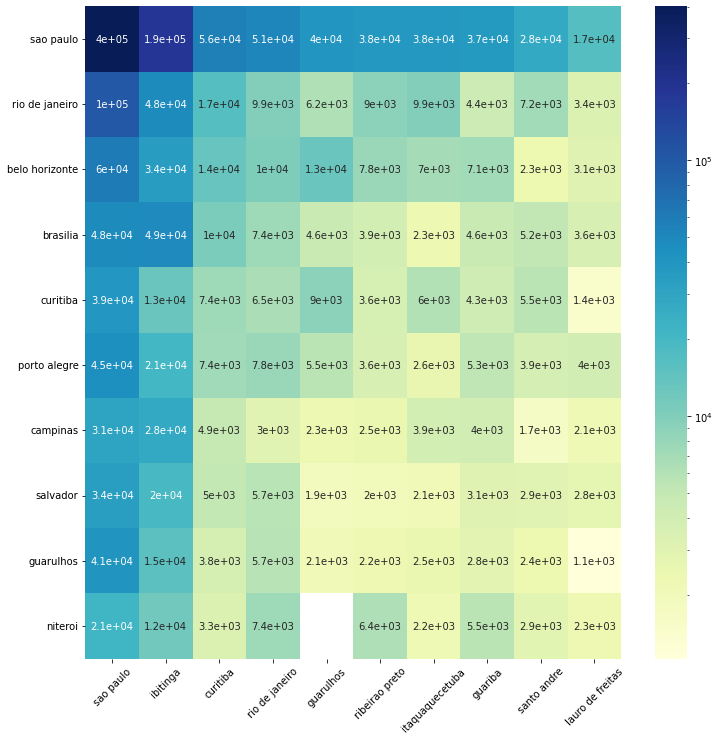

In [21]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (12,12))
ax = sns.heatmap(xy, cmap = 'YlGnBu', annot = True, norm = LogNorm())
ax.set_xticklabels(x_axis, rotation = '45')
ax.set_yticklabels(y_axis, rotation = 'horizontal')

# df2['seller_city_name'] = df2['seller_city'].apply(trans)
# df2['customer_city_name'] = df2['customer_city'].apply(trans)


In [22]:
city_seller_sales = geoproduct.copy()
city_seller_sales = city_seller_sales.groupby(by = ['seller_city']).sum()
city_seller_sales = city_seller_sales.sort_values(by = 'price',ascending = False)
city_seller_sales = city_seller_sales.reset_index(drop = False)
dft1 = city_seller_sales
city_seller_sales = city_seller_sales.loc[:19,]
city_seller_sales

,seller_city,price
0,sao paulo,2673549.42
1,ibitinga,622324.13
2,curitiba,460364.27
3,rio de janeiro,345923.02
4,guarulhos,279139.81
5,ribeirao preto,273828.06
6,itaquaquecetuba,230568.12
7,guariba,229472.63
8,santo andre,228441.90
9,lauro de freitas,225525.05


cities sales excessed 80% 11
key city:          seller_city       price
0          sao paulo  2673549.42
1           ibitinga   622324.13
2           curitiba   460364.27
3     rio de janeiro   345923.02
4          guarulhos   279139.81
5     ribeirao preto   273828.06
6    itaquaquecetuba   230568.12
7            guariba   229472.63
8        santo andre   228441.90
9   lauro de freitas   225525.05
10        piracicaba   211970.93


Text(0.5, 1.0, 'sales of each city to total sales(%)')

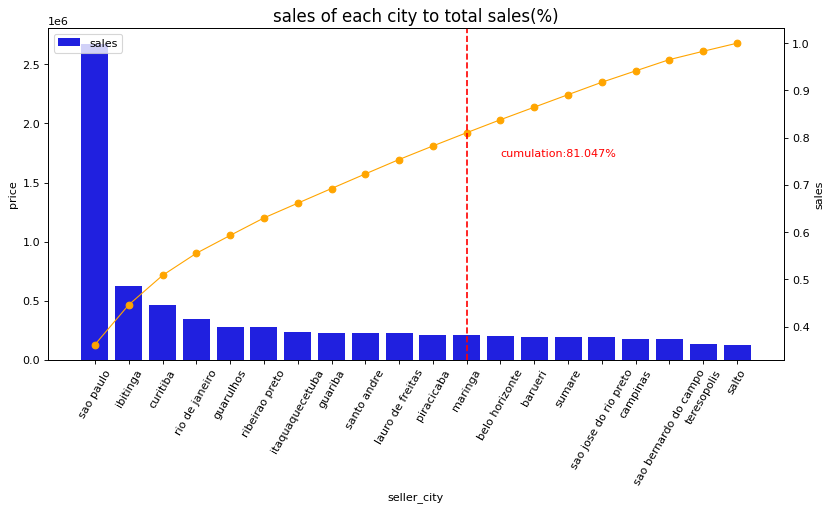

In [23]:
plt.figure(figsize=(10,5),dpi=80)

ax = sns.barplot(x = 'seller_city', y = 'price',data = city_seller_sales,label = 'sales', color = 'blue')
plt.tight_layout()
ax.set_xticklabels(labels = city_seller_sales['seller_city'],rotation = 60)
plt.legend(loc="upper left")
plt.twinx()
p=city_seller_sales['price'].cumsum()/city_seller_sales['price'].sum()
key = p[p>0.8].index[0]
key_num=city_seller_sales.index.tolist().index(key)
print('cities sales excessed 80%',key)
key_city = city_seller_sales[:key]
print('key city:',key_city)
 
p.plot(color = 'orange',style = '-o',linewidth=1)
plt.axvline(key_num,color="red",linestyle="--")
plt.text(key_num+1,p[key]-0.05,'cumulation:%.3f%%'%(p[key]*100),color="red")
plt.ylabel("sales")
plt.title("sales of each city to total sales(%)",fontsize=15)

In [24]:
city_customer_sales = geoproduct.copy()
city_customer_sales = city_customer_sales.groupby(by = ['customer_city']).sum()
city_customer_sales = city_customer_sales.sort_values(by = 'price',ascending = False)
city_customer_sales = city_customer_sales.reset_index(drop = False)
city_customer_sales = city_customer_sales.loc[:19,]
city_customer_sales

,customer_city,price
0,sao paulo,1886128.28
1,rio de janeiro,980899.05
2,belo horizonte,350175.53
3,brasilia,299235.34
4,curitiba,209901.64
5,porto alegre,187796.31
6,campinas,185738.45
7,salvador,178263.91
8,guarulhos,142681.68
9,niteroi,117141.14


cities sales excessed 80% 8
key city:     customer_city       price
0       sao paulo  1886128.28
1  rio de janeiro   980899.05
2  belo horizonte   350175.53
3        brasilia   299235.34
4        curitiba   209901.64
5    porto alegre   187796.31
6        campinas   185738.45
7        salvador   178263.91


Text(0.5, 1.0, 'sales of each city to total sales(%)')

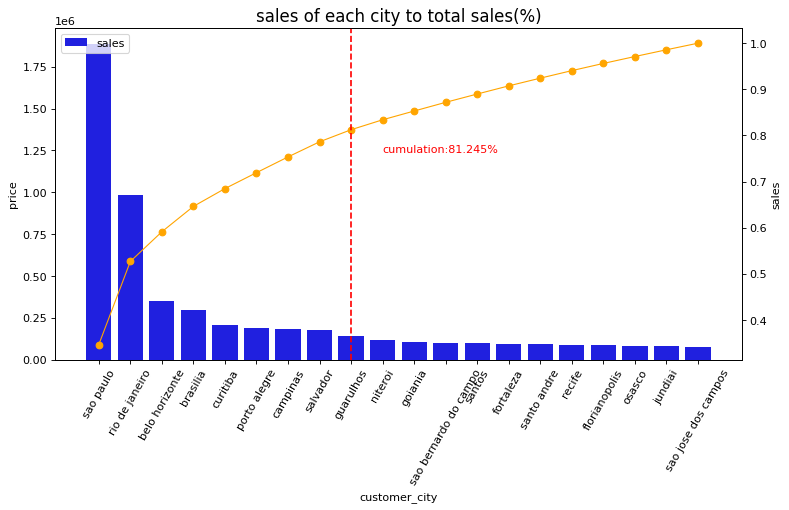

In [25]:
plt.figure(figsize=(10,5),dpi=80)

ax = sns.barplot(x = 'customer_city', y = 'price',data = city_customer_sales,label = 'sales', color = 'blue')
plt.tight_layout()
ax.set_xticklabels(labels = city_customer_sales['customer_city'],rotation = 60)

plt.legend(loc="upper left")
plt.twinx()
p=city_customer_sales['price'].cumsum()/city_customer_sales['price'].sum()
key = p[p>0.8].index[0]
key_num=city_customer_sales.index.tolist().index(key)
print('cities sales excessed 80%',key)
key_city = city_customer_sales[:key]
print('key city:',key_city)
 
p.plot(color = 'orange',style = '-o',linewidth=1)
plt.axvline(key_num,color="red",linestyle="--")
plt.text(key_num+1,p[key]-0.05,'cumulation:%.3f%%'%(p[key]*100),color="red")
plt.ylabel("sales")
plt.title("sales of each city to total sales(%)",fontsize=15)

In [26]:
city_seller_number = data[['seller_city']]
city_seller_number['count'] = 1
city_seller_number = city_seller_number.groupby('seller_city').sum()
city_seller_number = city_seller_number.sort_values(by = 'count', ascending = False)
city_seller_number = city_seller_number.reset_index(drop = False)
dft2 = city_seller_number
city_seller_number = city_seller_number.loc[:19,]
city_seller_number

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,seller_city,count
0,sao paulo,27767
1,ibitinga,7733
2,curitiba,2983
3,santo andre,2961
4,sao jose do rio preto,2573
5,belo horizonte,2515
6,rio de janeiro,2374
7,ribeirao preto,2245
8,maringa,2218
9,guarulhos,1975


cities sales excessed 80% 9
key city:              seller_city  count
0              sao paulo  27767
1               ibitinga   7733
2               curitiba   2983
3            santo andre   2961
4  sao jose do rio preto   2573
5         belo horizonte   2515
6         rio de janeiro   2374
7         ribeirao preto   2245
8                maringa   2218


Text(0.5, 1.0, 'sales of each city to total sales(%)')

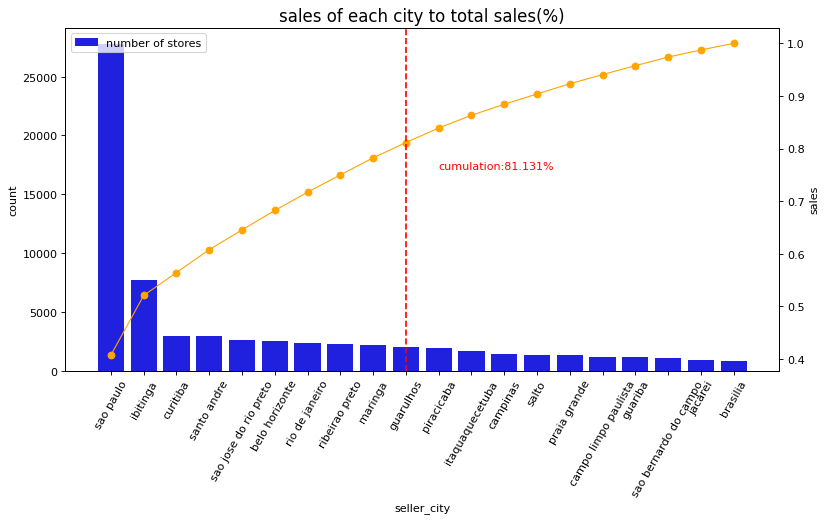

In [27]:
plt.figure(figsize=(10,5),dpi=80)

ax = sns.barplot(x = 'seller_city', y = 'count',data = city_seller_number,label = 'number of stores', color = 'blue')
plt.tight_layout()
ax.set_xticklabels(labels = city_seller_number['seller_city'],rotation = 60)

plt.legend(loc="upper left")
plt.twinx()
p=city_seller_number['count'].cumsum()/city_seller_number['count'].sum()
key = p[p>0.8].index[0]
key_num=city_seller_number.index.tolist().index(key)
print('cities sales excessed 80%',key)
key_city = city_seller_number[:key]
print('key city:',key_city)
 
p.plot(color = 'orange',style = '-o',linewidth=1)
plt.axvline(key_num,color="red",linestyle="--")
plt.text(key_num+1,p[key]-0.05,'cumulation:%.3f%%'%(p[key]*100),color="red")
plt.ylabel("sales")
plt.title("sales of each city to total sales(%)",fontsize=15)

In [28]:
city_customer_number = data[['customer_city']]
city_customer_number['count'] = 1
city_customer_number = city_customer_number.groupby('customer_city').sum()
city_customer_number = city_customer_number.sort_values(by = 'count', ascending = False)
city_customer_number = city_customer_number.reset_index(drop = False)
city_customer_number = city_customer_number.loc[:19,]
city_customer_number

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_city,count
0,sao paulo,17512
1,rio de janeiro,7710
2,belo horizonte,3088
3,brasilia,2360
4,curitiba,1734
5,campinas,1633
6,porto alegre,1586
7,salvador,1385
8,guarulhos,1313
9,sao bernardo do campo,1039


cities sales excessed 80% 8
key city:     customer_city  count
0       sao paulo  17512
1  rio de janeiro   7710
2  belo horizonte   3088
3        brasilia   2360
4        curitiba   1734
5        campinas   1633
6    porto alegre   1586
7        salvador   1385


Text(0.5, 1.0, 'sales of each city to total sales(%)')

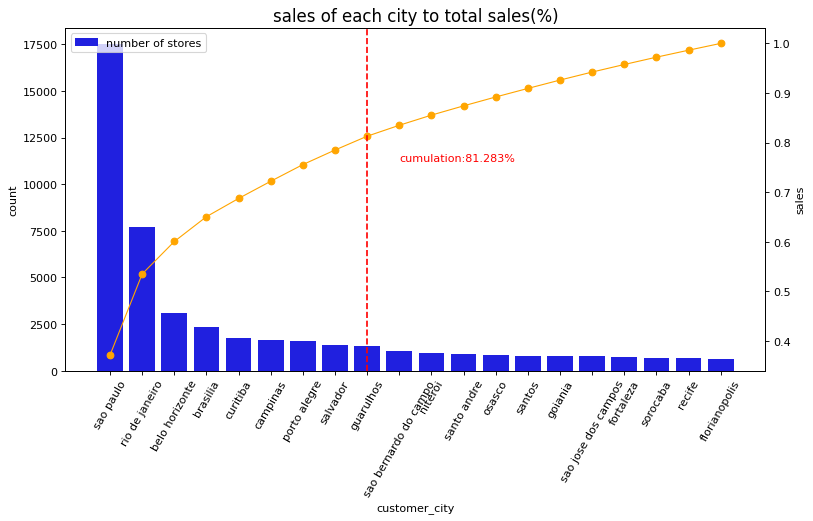

In [29]:
plt.figure(figsize=(10,5),dpi=80)

ax = sns.barplot(x = 'customer_city', y = 'count',data = city_customer_number,label = 'number of stores', color = 'blue')
plt.tight_layout()
ax.set_xticklabels(labels = city_customer_number['customer_city'],rotation = 60)

plt.legend(loc="upper left")
plt.twinx()
p=city_customer_number['count'].cumsum()/city_customer_number['count'].sum()
key = p[p>0.8].index[0]
key_num=city_customer_number.index.tolist().index(key)
print('cities sales excessed 80%',key)
key_city = city_customer_number[:key]
print('key city:',key_city)
 
p.plot(color = 'orange',style = '-o',linewidth=1)
plt.axvline(key_num,color="red",linestyle="--")
plt.text(key_num+1,p[key]-0.05,'cumulation:%.3f%%'%(p[key]*100),color="red")
plt.ylabel("sales")
plt.title("sales of each city to total sales(%)",fontsize=15)

In [30]:
seller = pd.merge(dft1, dft2, how = 'inner')
seller['avg_sales'] = seller['price'] / seller['count']
seller


,seller_city,price,count,avg_sales
0,sao paulo,2673549.42,27767,96.285138
1,ibitinga,622324.13,7733,80.476417
2,curitiba,460364.27,2983,154.329289
3,rio de janeiro,345923.02,2374,145.713151
4,guarulhos,279139.81,1975,141.336613
...,...,...,...,...
599,resende,19.99,1,19.990000
600,floranopolis,19.98,2,9.990000
601,jarinu,14.63,1,14.630000
602,macatuba,13.00,1,13.000000


In [31]:
seller = seller.sort_values(by = 'avg_sales', ascending = False)
seller = seller.reset_index(drop = False)
seller = seller.loc[:19,]
seller

,index,seller_city,price,count,avg_sales
0,171,bofete,9399.97,3,3133.323333
1,197,california,7630.00,6,1271.666667
2,163,paincandu,10220.50,9,1135.611111
3,387,dores de campos,899.00,1,899.000000
4,134,mamanguape,14368.61,16,898.038125
5,208,luiz alves,6729.50,8,841.187500
6,332,sao jose dos pinhais,1598.00,2,799.000000
7,117,guanambi,17522.00,22,796.454545
8,312,vitoria de santo antao,2217.99,3,739.330000
9,409,sbc,730.00,1,730.000000


Text(0.5, 1.0, 'avg_sales per store in cities')

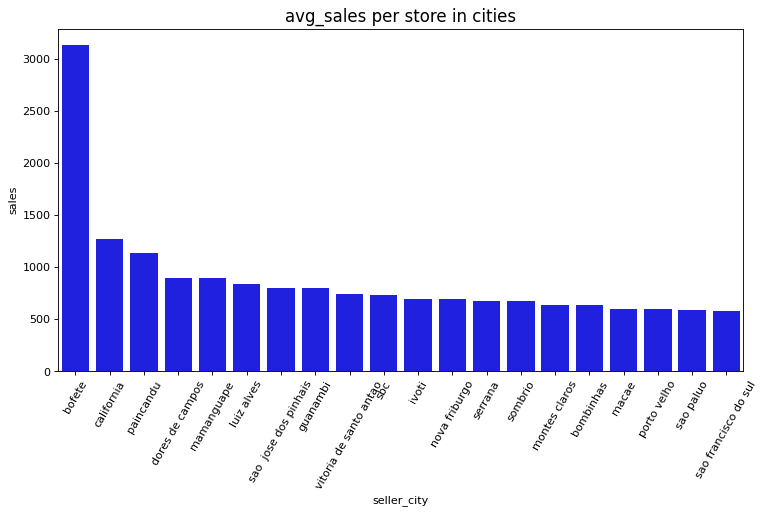

In [32]:
plt.figure(figsize=(10,5),dpi=80)

ax = sns.barplot(x = 'seller_city', y = 'avg_sales',data = seller,label = 'number of stores', color = 'blue')
plt.tight_layout()
ax.set_xticklabels(labels = seller['seller_city'],rotation = 60)

plt.ylabel("sales")
plt.title("avg_sales per store in cities",fontsize=15)